**Assignment 6**

[3 points] Delelop language model, which generates texts from wikipedia.
Use WikiText-2 dataset, also available in torchtext.datasets.
Use sentencepiece or tokenizers library for text tokenization. Pay attention to vocab size, probably subword tokens are better.

Your model should be autogressive RNN.

[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.

[1 point] Try to use together (sentencepiece or tokenizers), torchtext.datasets, and torchtext.data.BPTTIterator


Text generation should be terminated when either max length is reached or terminal symbol is generated.
Explore several inference techniques:

[1 point] Argmax

[1 point] Beamsearch

[1 point] Sampling from probabilty distribution with temperature

[1 point] Nucleus sampling

[1 point] Top-k sampling

For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

In [1]:
pip install tokenizers

In [0]:
import pandas as pd
import numpy as np
import nltk
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchtext.data import Field, LabelField, RawField, BPTTIterator
from torchtext.datasets import WikiText2

from tokenizers import SentencePieceBPETokenizer

from tqdm import tqdm
from tqdm import tqdm_notebook

SEED = 42
np.random.seed(SEED)

In [3]:
WikiText2.download(root = '/content/gdrive/My Drive/Colab Notebooks')

'/content/gdrive/My Drive/Colab Notebooks/wikitext-2/wikitext-2'

In [0]:
parts = ['train','valid','test']
path = '/content/gdrive/My Drive/Colab Notebooks/wikitext-2/wikitext-2'
for i in parts:
  f_name = path + f'/wiki.{i}.tokens'
  with open(f_name, 'r') as f:
    if i == 'train':
      train = f.read()
    elif i == 'valid':
      valid = f.read()
    elif i == 'test':
      test = f.read()

In [5]:
print(f'Train length = {len(train):7}')
print(f'Valid length = {len(valid):8}')
print(f'Test length  = {len(test):8}')

Train length = 10780437
Valid length =  1120192
Test length  =  1255018


In [6]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.add_special_tokens(['<unk>'])

1

In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/wikitext-2/wikitext-2'
train_text = path + '/wiki.train.tokens'
valid_text = path + '/wiki.valid.tokens'
test_text = path + '/wiki.test.tokens'
tokenizer.train([train_text, valid_text, test_text], vocab_size=10000)

In [0]:
def tok_func(tokenizer, text):
  return tokenizer.encode(text).tokens

In [12]:
TEXT = Field(sequential=True, include_lengths=False, batch_first=True, tokenize=lambda x: tok_func(tokenizer, x),lower=True, pad_first=True)
train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, test)
vocab = TEXT.vocab

print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 8571


['<unk>', '<pad>', '▁the', '▁', '▁,', '▁.', '▁of', '▁and', '▁in', '▁to']

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')

In [0]:
train_iter, valid_iter, test_iter = BPTTIterator.splits((train, valid, test),
    batch_size=64,
    bptt_len=30,
    repeat=False,
    device=device)

In [15]:
batch = next(iter(train_iter))
print(batch.text[:3, 0])
print(batch.target[:3, 0])

tensor([ 3, 11, 12])
tensor([  11,   12, 6854])


# Training model

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):

        if hasattr(batch, 'text'):
          x = batch.text.T
        else:
          x = batch
        
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        
        return x.transpose(1,2)

In [0]:
batch_size = 64

model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

model = model.to(device)
criterion = criterion.to(device)


In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    train_losses = []

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss, train_losses

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    n_batches = len(iterator)

    valid_losses = []

    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            epoch_loss += loss.data.item()

            valid_losses.append(loss.item())

    return epoch_loss / n_batches, valid_losses

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    all_train_losses = []
    all_valid_losses = []

    for epoch in range(n_epochs):
        train_loss, i_train_losses = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, i_valid_losses = _test_epoch(model, valid_iterator, criterion)
        all_train_losses.append(i_train_losses)
        all_valid_losses.append(i_valid_losses)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, all_train_losses, all_valid_losses

In [21]:
history_df, res_train_losses, res_valid_losses = nn_train(model, train_iter, valid_iter, criterion, optimizer, scheduler=scheduler, 
        n_epochs=5, early_stopping=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



validation loss 2.79120



validation loss 1.35951



validation loss 0.68045



validation loss 0.40613



validation loss 0.29556


In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=200,
                hidden_size=128,
               )

In [23]:
from sklearn.externals import joblib
joblib.dump(model, "rnn_model.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['rnn_model.pkl']

In [0]:
my_model = joblib.load("rnn_model.pkl")

# Plot

In [26]:
history_df

,epoch,train_loss,valid_loss
0,0.0,4.573957,2.791198
1,1.0,2.043530,1.359507
2,2.0,0.929708,0.680454
3,3.0,0.467348,0.406129
4,4.0,0.294789,0.295560


In [0]:
import matplotlib.pyplot as plt

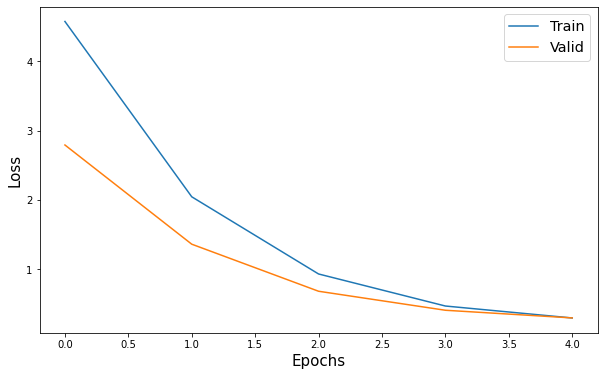

In [28]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history_df['train_loss'])), history_df['train_loss'], label='Train')
plt.plot(np.arange(len(history_df['valid_loss'])), history_df['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

# Prediction

In [29]:
def num2text(sequence):
  text = [TEXT.vocab.itos[v] for v in sequence]
  return text

print(batch.text[:10, 1])
print(num2text(batch.text[:10, 1]))

tensor([   2, 3897,   31,   14,   93,  804,  129, 6604,  532,  120])
['▁the', '▁myth', 's', '▁was', '▁more', '▁important', '▁than', '▁elaborate', '▁story', 't']


In [0]:
def join_text(text_list): 
  s = num2text(text_list)
  return ''.join(s).replace('▁', ' ').strip()

In [31]:
join_text(batch.text[:10, 1])

'the myths was more important than elaborate storyt'

In [0]:
def generate(model, func, start, max_len=30, eos='<eos>'):
  token = start
  with tt.no_grad():
      seq = [token]
      i = 0
      while i < max_len and token != TEXT.vocab.stoi[eos]:
        i += 1
        pred = model(tt.tensor([seq]))[:,:,-1]
        token = func(pred)
        seq.append(token)

  return join_text(seq)

# Argmax

In [0]:
def argmax(pred):
  return tt.argmax(pred).item()

In [0]:
seed = TEXT.vocab.stoi['myths']

In [35]:
print(generate(my_model, argmax, start=seed))

<unk>agues stephenagues stephenagues stephenagues strategyfer election druagues strategyfer election druagues strategyfer election druagues strategyfer election druagues strategyfer election


## Beam search

In [0]:
def beam_search(input_seq, model=model, max_length=35, k=3, end_token=vocab.stoi['<eos>']):
    """
    imput_seq:  Torch tensor 1d
    return: List of k sequences of token_ids.
    """
    beam = [(input_seq, 0)]
    start_tokens = input_seq.unsqueeze(0)
    
    with torch.no_grad():
        counter = 0        
        while counter < max_length:

            candidates = []
            counter += 1

            for start, prob in beam:
        
                if (start[-1] == end_token) and counter >= 15:
                    candidates.append(start)
                
                else:
                    pred = my_model(start.unsqueeze(0)) #start_tokens
                    pred = pred.transpose(1,2) # (batch_size, seq_length, vocab_size)

                    sorted_idx = torch.argsort(pred, dim=2, descending=True)[0,-1,:][:k]
                    sorted_logits = torch.sort(pred, dim=2, descending=True).values[0,-1,:][:k]

                    candidates += [(torch.cat((start, sorted_idx[i].unsqueeze(0))), 
                                    prob + sorted_logits[i].item()) for  i in range(k)]
            beam = sorted(candidates, key=lambda x:x[1])[:k] 
    return beam

In [0]:
import torch
import re 

def decode(sequence):
    return [vocab.itos[token] for token in sequence]

def make_text(sequence):
    
    text = ''

    for element in sequence:
        if element.startswith('▁'):
            text += element[1:] if len(element) > 1 else ' '
        else:
            text += element
        text += ' '
    text = re.sub(r'\s{2,5}', ' ', text)
    return text

In [45]:
predict = []
for i, batch in enumerate(test_iter):
    if i % 14 == 0 and i > 0:
        predict.append(batch.text[:6, 1])
predict.append(torch.tensor([5]).to(device))

for ind, el in enumerate(predict):
        beams = beam_search(input_seq=el)
        print('EXAMPLE № {}'.format(ind))
        for element in beams:
            element = decode(element[0].tolist())
            initial = element[:len(el)]
            generated = element[len(el):]
            print('Text: ', make_text(initial))
            print('Generated Text: ', make_text(generated))
            print(' ')

EXAMPLE № 0
Text:  for his <unk> , a 
Generated Text:  characteristics fer mm version agues stephen stephen jes feud bur fer fer fer rhythm green jes feud feud bur fer fer fer schools op. fer fer fer rhythm feud feud bur agues format 20th election 
 
Text:  for his <unk> , a 
Generated Text:  characteristics fer mm version agues stephen stephen jes feud bur fer fer fer rhythm green jes feud feud bur fer fer fer schools op. fer fer fer rhythm feud feud format ulysses format classified inform 
 
Text:  for his <unk> , a 
Generated Text:  characteristics fer mm version agues stephen stephen jes feud bur fer fer fer rhythm green jes feud feud bur fer fer fer schools op. fer fer fer rhythm feud feud format ulysses format classified fer 
 
EXAMPLE № 1
Text:  the influence of du fu in 
Generated Text:  agues fer election fer agues stephen debate fer fer fer rhythm green mm version strategy ified strategy strongest format edy leg mm 1976 downtown study fer fer inform green mm agues stephen rup

# Top-K Sampling

In [0]:
import torch

def top_k(pred, top_k=2):

    min_val = torch.topk(pred, top_k)[0][..., -1, None]
    extra_ids = pred < min_val
    pred[extra_ids] = -float("Inf")

    return torch.multinomial(torch.exp(pred), 1)

In [47]:
generate(my_model, top_k, start=seed)

'<unk> venus belongfer layeragues dru formatfer election druferency dru formatagues strategy election openagues strategy election druagues strategy election druaguesfer debate green'

# With temperature

In [0]:
def tau_2(probs, tau=1):

  probs = probs.detach()
  dop = probs/tau
  res = tt.exp(dop)/tt.sum(tt.exp(dop))
  res = res.squeeze()
  res = res.numpy()/np.sum(res.numpy())
  result = np.random.choice(len(res), 1, p=res)[0]
  
  return result

In [53]:
generate(model, tau_2, seed)

'<unk> recognizedaval roc austrianont passed cameuments ready measuredthilton ordering arm particularature newspaper bes fictional richmond ast worked 49 chose zone remove lyrics defended genre york'

# Nucleus

In [0]:
def tau_dop(probs, tau = 1):
  probs = probs.detach()
  dop = probs/tau
  res = tt.exp(dop)/tt.sum(tt.exp(dop))
  res = res.squeeze()
  if np.sum(res.numpy()) == 1:
    res = res.numpy()
  else:
    res = res.numpy()/np.sum(res.numpy())
    
  return res

In [0]:
def nucleus(probs, p = 0.5):
  cumul = 0
  num = 0

  probs = probs.detach().squeeze()
  new_probs =  tt.tensor(tau_dop(probs))
  sorted_probs = tt.argsort(new_probs, descending=True)

  while cumul < p:
    prob_id = sorted_probs[num]
    cumul += new_probs[prob_id]
    num += 1

  top_ids = sorted_probs[:num]
  top_probs = new_probs[top_ids]
  result = np.random.choice(top_ids.numpy(), 1, p=tau_dop(top_probs))[0]

  return result

In [57]:
gen_t_nucl = generate(my_model, nucleus, seed)

print(gen_t_nucl)

<unk> attorney 19thection shorter europiumroadgy beth 105ṅsa rhodes thinraft momentither storm romani animals 250ements coordin din 1990 dism english influṃ roxas diplom


In [58]:
generate(my_model, nucleus, seed)

'<unk> formal` fif titles rulingorganshore keats rareuments scientology stylesfield ide ag listed abs 3 footenth canad collebc vol bombs 20 inter explo watson named'